# MSDS 7331 - Project 2
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Project_2

### Tasks

Ryan:
1. bring over pre-processing code


Dineen:
1. dividing your data into training and testing splits


Dale:
1. Gridsearch

In [5]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# other
import time
import warnings

### Data Preparation (15 points total)
* [10 points] Define and prepare your class variables. Use proper variable
representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for
the analysis.

* The following were converted 'AGE', 'SEX','MARRIAGE', 'LIMIT_BAL': 
  * One hot encoding of MARRIAGE
  * SEX was converted to isMale
  * AGE was converted to age ranges
  * LIMIT_BAL was converted to limit ranges
* We use scaled data (Standard Scaled) to bring the payment levels and monthly counts into a common scale
* We will use StratifiedKFold to create mulitple train/test data sets for cross validation
  * We have enough samples that we do not see any weakness of using StratifiedKFold
* We use manually selected attributes for a Logistic Model to improve the fit
  * Here we will try PCA
  * We will use Pipelines to match the attribute reduction with the model

* We will use GridSearch to look for optimal parameters for various models, including visualization
of the parameters and their resulting models

* We will use ROC Curves and AUC scores to decide on the best model
* We will use visulazations throughout, but especially in justyfying our model selection
* We will document the most important attributes


In [6]:
#
# need to modify this to be the shortened version from the previous exercises, 
# but include the data processing from the raw data
#
# load preprocessed data from previous lab

data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
#data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')
cc_data.info(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

In [7]:
# sample PCA code
cc_data_target = cc_data['default payment next month'].values
cc_data_Xs = cc_data.drop('default payment next month', axis='columns').values

# Column names for labeling
cc_data_Xs_names = cc_data.drop('default payment next month', axis='columns').columns

#PCA or LDA code
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.lda import LDA

#copy the data to use code from sample
X = cc_data_Xs
y = cc_data_target
target_names = cc_data_Xs_names

pca = PCA(n_components=4)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=4)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


pca: [[  7.03060667e-08   1.37321230e-06   1.82097029e-06   1.80072879e-06
    1.81882014e-06   1.85172415e-06   1.91629948e-06   4.46548409e-01
    4.40869138e-01   4.29188036e-01   3.97481527e-01   3.69467793e-01
    3.52658561e-01   2.49803082e-02   2.84029663e-02   2.38468235e-02
    1.93466173e-02   1.90055882e-02   2.06290376e-02   2.83173615e-07
    6.80505498e-07   8.29640039e-08   8.05617211e-08  -1.55793064e-08
   -6.49824147e-08]
 [  6.04971588e-07  -1.19409232e-06  -1.49848312e-06  -3.80779572e-07
    1.26319071e-06   2.67179546e-06   3.68034715e-06  -5.48944059e-01
   -3.93810709e-01  -5.03802197e-02   2.57491990e-01   4.24129880e-01
    4.79721053e-01   4.36006247e-02   1.69290793e-01   1.41901167e-01
    1.00085860e-01   6.20487304e-02  -1.22986756e-02  -2.48042707e-07
    5.52403989e-07  -3.54448804e-07  -7.54289769e-09  -3.03961951e-08
    3.79390928e-08]
 [  8.42248801e-07  -3.94776393e-06  -4.20183915e-06  -3.32106245e-06
   -1.28040540e-06  -2.27433106e-06  -3.58395

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.00*EDUC +0.00*PAY_0 +0.00*PAY_ +0.00*PAY_3 +0.00*PAY_4 +0.00*PAY_ +0.00*PAY_6_ +0.45*BILL_AMT1 +0.44*BILL_AMT +0.43*BILL_AMT3 +0.40*BILL_AMT4 +0.37*BILL_AMT +0.35*BILL_AMT6_ +0.02*PAY_AMT1 +0.03*PAY_AMT +0.02*PAY_AMT3 +0.02*PAY_AMT4 +0.02*PAY_AMT +0.02*PAY_AMT6_ +0.00*AGE_ +0.00*LIMIT_BAL_ +0.00*i +0.00*Marriage_Ma -0.00*Marriage_O -0.00*Marriage_S 
0.00*EDUC -0.00*PAY_0 -0.00*PAY_ -0.00*PAY_3 +0.00*PAY_4 +0.00*PAY_ +0.00*PAY_6_ -0.55*BILL_AMT1 -0.39*BILL_AMT -0.05*BILL_AMT3 +0.26*BILL_AMT4 +0.42*BILL_AMT +0.48*BILL_AMT6_ +0.04*PAY_AMT1 +0.17*PAY_AMT +0.14*PAY_AMT3 +0.10*PAY_AMT4 +0.06*PAY_AMT -0.01*PAY_AMT6_ -0.00*AGE_ +0.00*LIMIT_BAL_ -0.00*i -0.00*Marriage_Ma -0.00*Marriage_O +0.00*Marriage_S 
0.00*EDUC -0.00*PAY_0 -0.00*PAY_ -0.00*PAY_3 -0.00*PAY_4 -0.00*PAY_ -0.00*PAY_6_ -0.19*BILL_AMT1 -0.04*BILL_AMT +0.54*BILL_AMT3 +0.07*BILL_AMT4 -0.21*BILL_AMT -0.31*BILL_AMT6_ +0.20*PAY_AMT1 +0.68*PAY_AMT +0.04*PAY_AMT3 -0.03*PAY_AMT4 +0.03*PAY_AMT +0.14*PAY_AMT6_ +0.00*AGE_ +0.00*LIMIT_BAL_

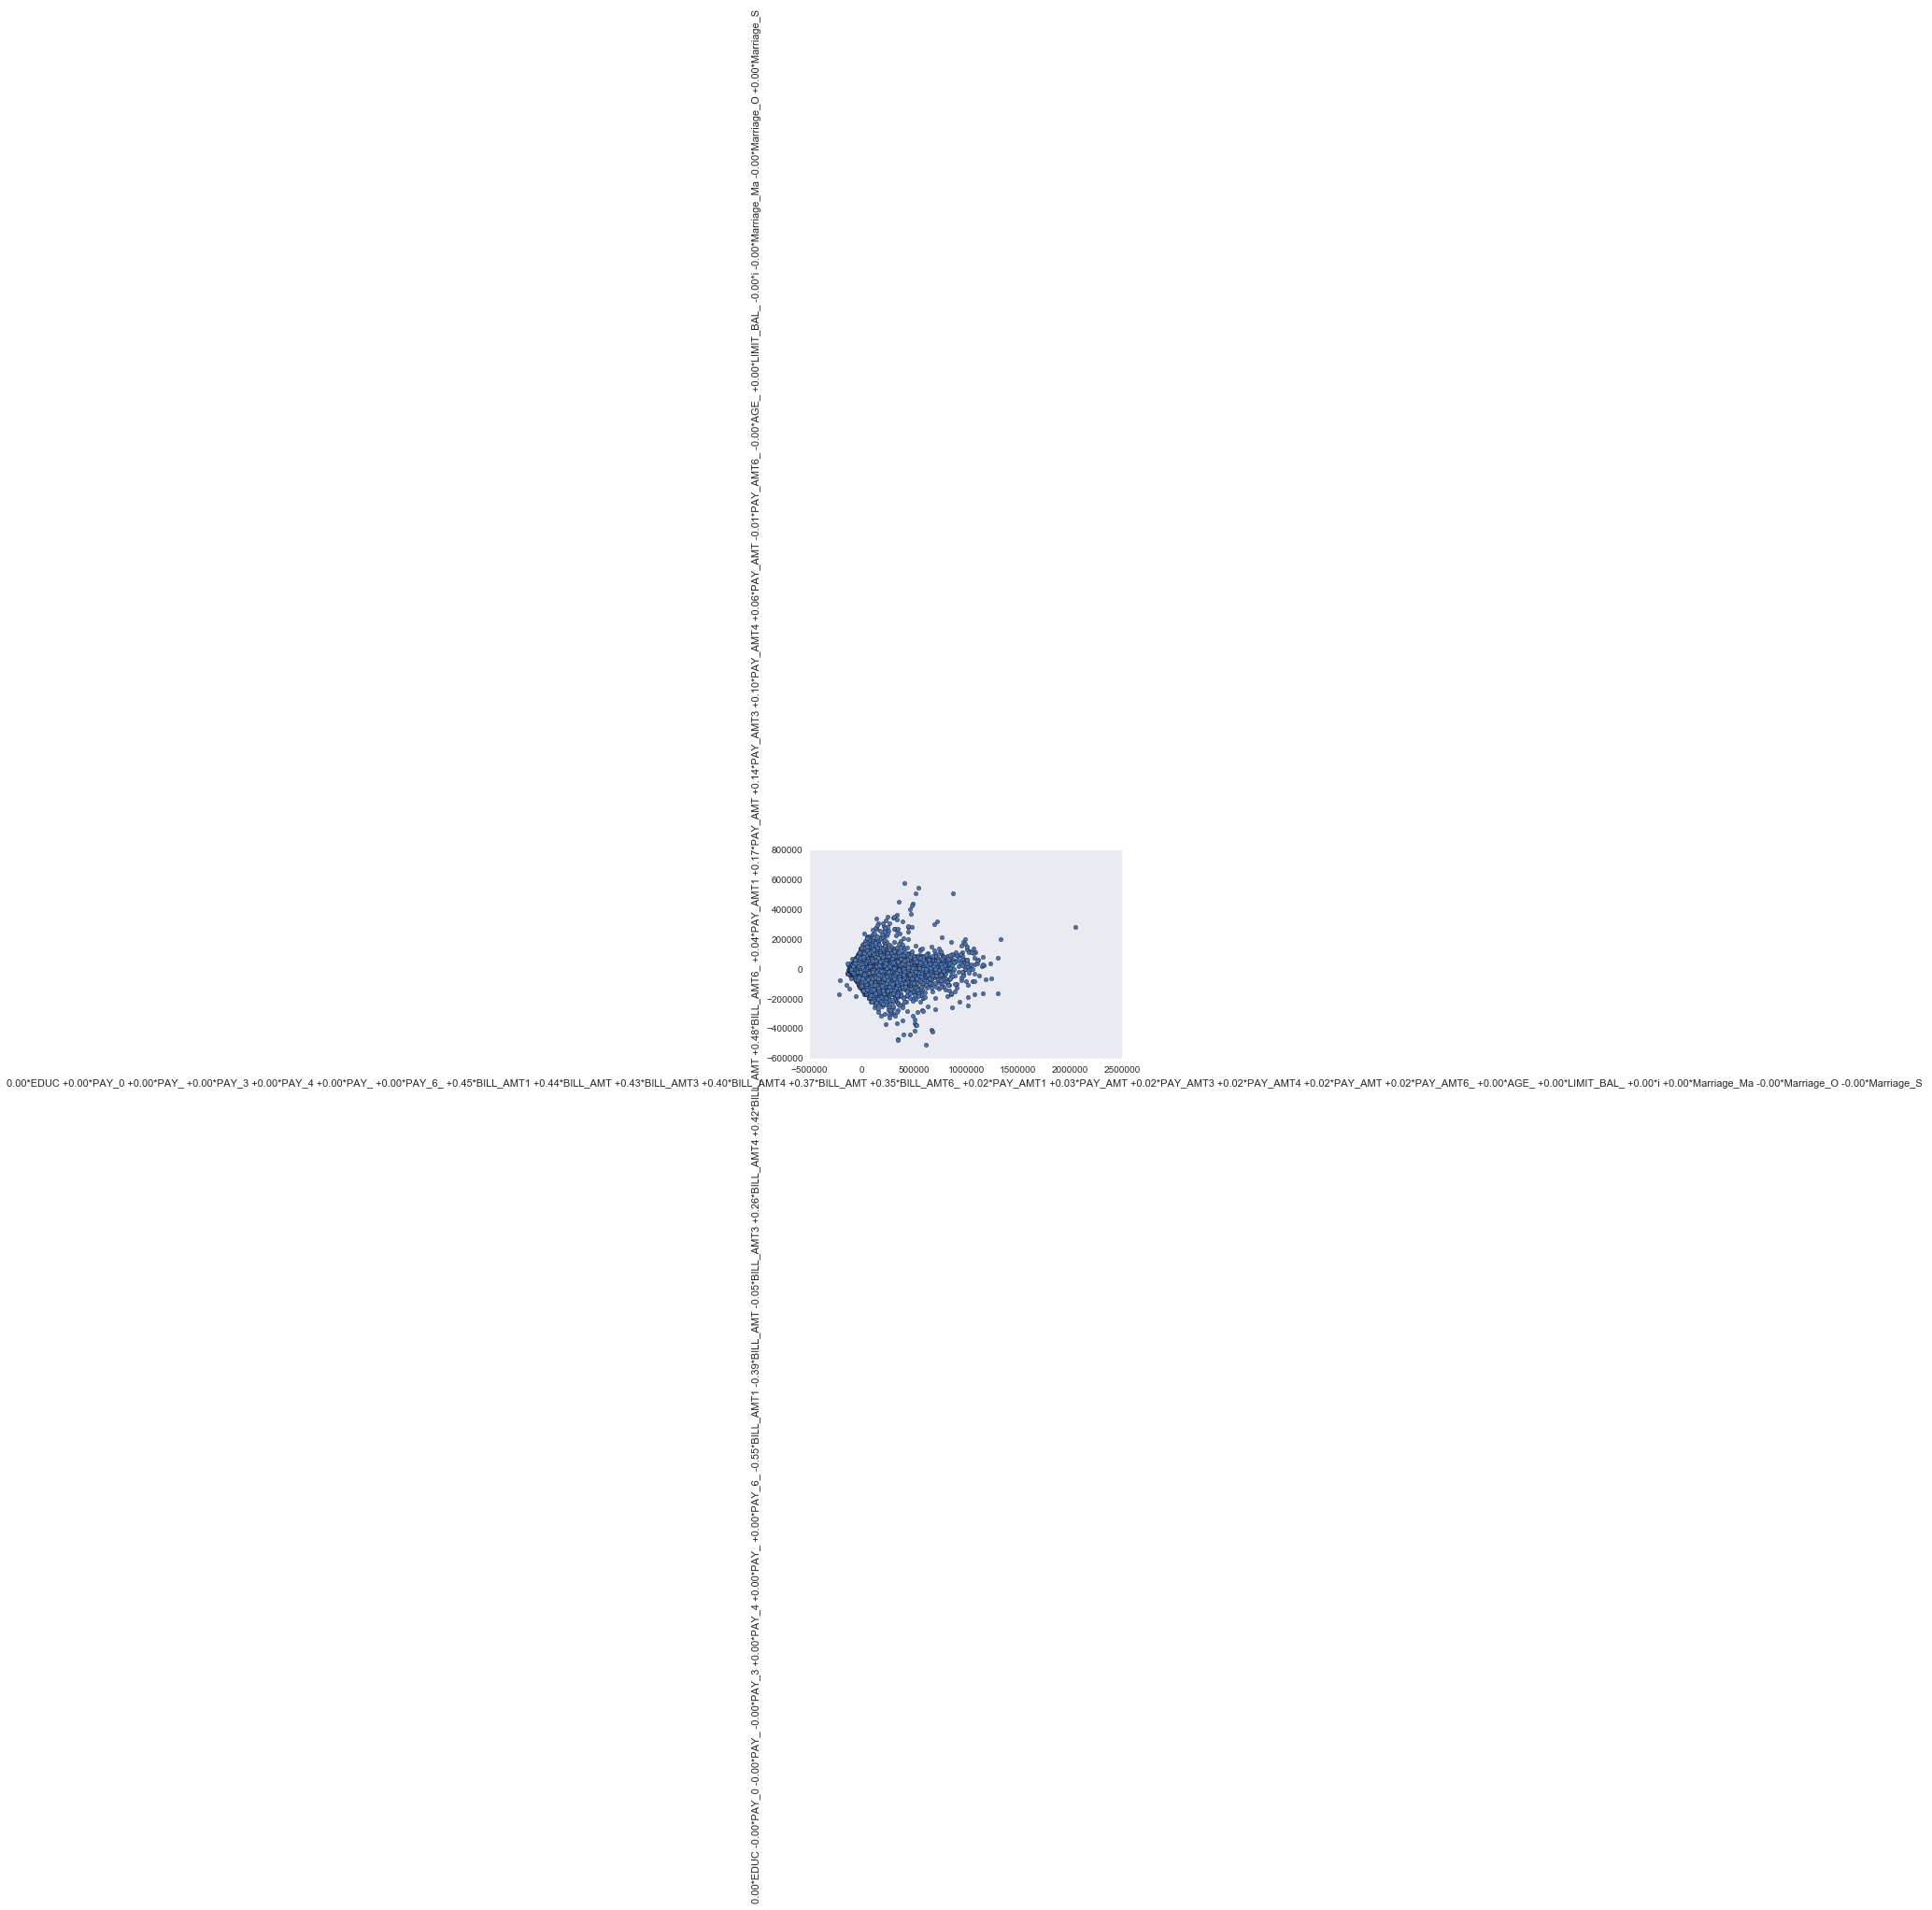

In [12]:
%matplotlib inline
# this function definition just formats the weights into readable strings
# you can skip it without loss of generality to the Data Science content
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
# now let's get to the Data Analytics!
pca_weight_strings = get_feature_names_from_weights(pca.components_, cc_data_Xs_names) 
lda_weight_strings = get_feature_names_from_weights(lda.scalings_.T, cc_data_Xs_names) 

# create some pandas dataframes from the transformed outputs
df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])
df_lda = pd.DataFrame(X_lda,columns=[lda_weight_strings])

from pandas.tools.plotting import scatter_plot

print(pca_weight_strings[0])
print(pca_weight_strings[1])
print(pca_weight_strings[2])
print(pca_weight_strings[3])
print(lda_weight_strings)
# plot is broken.
# scatter plot the output, with the names created from the weights
ax = scatter_plot(df_pca, pca_weight_strings[0], pca_weight_strings[1])
newfig = plt.figure()
#ax = scatter_plot(df_lda, 'x', 'x')
plt.show()

### Data Preparation (15 points total) - part 2

* [5 points] Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created).

<font color='Red'>Not Complete</font>


#### Convert data to numpy arrays for training

In [5]:
cc_data_target = cc_data['default payment next month']
cc_data_Xs = cc_data.drop('default payment next month', axis='columns')

# Column names for labeling
cc_data_Xs_names = cc_data.drop('default payment next month', axis='columns').columns

### Modeling and Evaluation (70 points total)

* [10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)
appropriate for analyzing the results of your modeling? Give a detailed explanation
backing up any assertions.

<font color='Red'>Not Complete</font>

    ROC Curves and AUC scores are good measures for imbalanced data scources. "The main goal for learning from imbalanced datasets is to improve the recall without hurting the precision...The F-value metric is one measure that combines the trade-offs of precision and recall, and outputs a single number reflecting the "goodness" of a classifier in the presence of rare classes. "
    https://www3.nd.edu/~dial/publications/chawla2005data.pdf

    From Wikipedia:
    "Precision (also called positive predictive value) is the fraction of retrieved instances that are relevant"
    "Recall (also known as sensitivity) is the fraction of relevant instances that are retrieved."
    https://en.wikipedia.org/wiki/Precision_and_recall

In [ ]:
# Find a evaluation metric the is compareable for binary and multiclassification 

* [10 points] Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For
example, if you are using time series data then you should be using continuous training
and testing sets across time.

<font color='Red'>Not Complete</font>


In [ ]:
# For dividing data we will use stratified 10 fold
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html
from sklearn.cross_validation import StratifiedKFold

In [ ]:
>>> from sklearn.cross_validation import StratifiedKFold
>>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
>>> y = np.array([0, 0, 1, 1])
>>> skf = StratifiedKFold(y, n_folds=2)
>>> len(skf)
2
>>> print(skf)  
sklearn.cross_validation.StratifiedKFold(labels=[0 0 1 1], n_folds=2,
                                         shuffle=False, random_state=None)
>>> for train_index, test_index in skf:
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]
.. automethod:: __init__

* [20 points] Create three different classification/regression models for each task (e.g.,
random forest, KNN, and SVM for task one and the same or different algorithms for
task two). Two modeling techniques must be new (but the third could be SVM or
logistic regression). Adjust parameters as appropriate to increase generalization
performance using your chosen metric. You must investigate different parameters
of the algorithms!

<font color='Red'>Not Complete</font>

In [13]:
# The three different classifications we will use will be logistic regression, random forest, and KNN

# Task 2 find alternative prediction to default; find 3 levels of risk groups, high, medium, low

# Apply gridsearchCV

* [10 points] Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why
they are interesting to someone that might use this model.

<font color='Red'>Not Complete</font>

In [ ]:
# Draw the ROC for default evaluation

# Show something else for the risk grouping

* [10 points] Discuss the advantages of each model for each classification task, if any. If
there are not advantages, explain why. Is any model better than another? Is the
difference significant with 95% confidence? Use proper statistical comparison methods.
You must use statistical comparison techniques—be sure they are appropriate for your
chosen method of validation as discussed in unit 7 of the course.

<font color='Red'>Not Complete</font>

In [ ]:
# Look more into this later

* [10 points] Which attributes from your analysis are most important? Use proper
methods discussed in class to evaluate the importance of different attributes. Discuss
the results and hypothesize about why certain attributes are more important than others
for a given classification task.

<font color='Red'>Not Complete</font>

In [ ]:
# Figure this out later

Deployment (5 points total)
* How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it for prediction)? How would you measure the model's value if it
was used by these parties? How would your deploy your model for interested parties?
What other data should be collected? How often would the model need to be updated,
etc.?

<font color='Red'>Not Complete</font>
* The models provide a starting point for interested parties, identifying the most fruitful models with the data available. From this point, a conversation would be in order with the prospective model users about additional data that would enhance predictions and cover corner cases, and request additional data to test and validate again. 
* To measure the value, one would implement the model in a business setting. This is envisioned as  customer advisers calling customers that are going to default to offer help or whatever action the business sees fit to take to avoid that outcome. At the point where the CC company has fewer defaults and people have fewer defaults to struggle with, then you have a valid measurement: old default rate versus new default rate.
* Updates to the model would be determined by its overall impact to the customer and company, combined with new ideas that develop as the model is tweaked to come up with better predictions. At some point the tweaks will not significantly improve the prediction at which time the company may decide to just keep it as-is and move the resource to more productive problems that need to be tackled. 


In [ ]:
# Other data: Add credit score 

Exceptional Work (10 points total)
* You have free reign to provide additional analyses.
* One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a
good model for each classification algorithm?

<font color='Red'>Not Complete</font>



In [ ]:
# Try and use gridsearch in the above